# Project Overview

This project analyzes machine learning job postings across the United States using NLP techniques.  
We will perform the following:
- Explore data distribution and key insights.
- Clean and preprocess job descriptions.
- Perform topic modeling.
- Conduct sentiment analysis.
- Visualize trends over time and by seniority level.

In [ ]:
import pandas as pd
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from textblob import TextBlob
import matplotlib.pyplot as plt



## Load Dataset

Load the provided dataset and display its structure.


In [ ]:
df = pd.read_csv('1000_ml_jobs_us.csv')
df.head()

,Unnamed: 0,job_posted_date,company_address_locality,company_address_region,company_name,company_website,company_description,job_description_text,seniority_level,job_title
0,0,2024-10-31,Indianapolis,Indiana,Upper Hand,https://upperhand.com,Upper Hand is the leading provider of full-sui...,OverviewUpper Hand is embarking on an exciting...,Internship,Internship - Machine Learning Engineer & Data ...
1,1,2025-03-14,San Francisco,California,Ikigai,https://www.ikigailabs.io,"Built upon years of MIT research, Ikigai is a ...",Company DescriptionThe Ikigai platform unlocks...,Mid-Senior level,Machine Learning Engineer
2,2,2025-04-09,San Jose,CA,Adobe,http://www.adobe.com,Adobe is the global leader in digital media an...,Our CompanyChanging the world through digital ...,Entry level,Machine Learning Engineer
3,3,2025-03-22,Mountain View,California,Waymo,https://waymo.com/careers/,On the journey to be the world's most trusted ...,Waymo is an autonomous driving technology comp...,Entry level,"Machine Learning Engineer, Training"
4,4,2025-03-28,Boston,Massachusetts,HMH,http://www.hmhco.com,We are an adaptive learning company that empow...,Job Title: Machine Learning EngineerLocation: ...,Mid-Senior level,Machine Learning Engineer


## Text Preprocessing

Clean the job descriptions to remove noise:
- Remove URLs and special characters.
- Convert text to lowercase.
- Remove stopwords.

In [ ]:
import re
from sklearn.feature_extraction.text import CountVectorizer

stop_words = set(CountVectorizer(stop_words='english').get_stop_words())

def clean_text(text):
    if not isinstance(text, str):
        return ''
    text = re.sub(r"http\\S+|@\\S+|#\\S+", '', text)
    text = re.sub(r'[^a-zA-Z\\s]', '', text)
    text = text.lower()
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

df['clean_text'] = df['job_description_text'].apply(clean_text)
df[['job_description_text', 'clean_text']].head()

,job_description_text,clean_text
0,OverviewUpper Hand is embarking on an exciting...,overviewupperhandisembarkingonanexcitingjourne...
1,Company DescriptionThe Ikigai platform unlocks...,companydescriptiontheikigaiplatformunlocksthep...
2,Our CompanyChanging the world through digital ...,ourcompanychangingtheworldthroughdigitalexperi...
3,Waymo is an autonomous driving technology comp...,waymoisanautonomousdrivingtechnologycompanywit...
4,Job Title: Machine Learning EngineerLocation: ...,jobtitlemachinelearningengineerlocationremotew...


## Topic Modeling using LDA

We will apply Latent Dirichlet Allocation (LDA) to discover hidden topics in the job descriptions.

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation

vectorizer = CountVectorizer(max_df=0.9, min_df=10, stop_words='english')
dtm = vectorizer.fit_transform(df['clean_text'])
lda_model = LatentDirichletAllocation(n_components=10, random_state=42)
lda_model.fit(dtm)
feature_names = vectorizer.get_feature_names_out()

def get_top_words(model, feature_names, n_top_words=10):
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        top_features = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        topics.append(f"Topic {topic_idx}: {' '.join(top_features)}")
    return topics

top_topics = get_top_words(lda_model, feature_names)
for topic in top_topics:
    print(topic)

Topic 0: snapincisatechnologycompanywebelievethecamerapresentsthegreatestopportunitytoimprovethewaypeopleliveandcommunicatesnapcontributestohumanprogressbyempoweringpeopletoexpressthemselvesliveinthemomentlearnabouttheworldandhavefuntogetherthecompanysthreecoreproductsaresnapchatavisualmessagingappthatenhancesyourrelationshipswithfriendsfamilyandtheworldlensstudioanaugmentedrealityplatformthatpowersaracrosssnapchatandotherservicesanditsarglassesspectaclessnapengineeringteamsbuildfunandtechnicallysophisticatedproductsthatreachhundredsofmillionsofsnapchattersaroundtheworldeverydayweredeeplycommittedtothewellbeingofeveryoneinourglobalcommunitywhichiswhyourvaluesareattherootofeverythingwedowemovefastwithprecisionandalwaysexecutewithprivacyattheforefrontwerelookingforamachinelearningengineertojoinsnapincwhatyoulldocreatemodelswhichhelpdrivevalueforusersadvertisersandourcompanyevaluatethetechnicaltradeoffsofeverydecisionperformcodereviewsandensureexceptionalcodequalitybuildrobustlastingandsc

## Sentiment Analysis

Analyze sentiment of the job descriptions using TextBlob.

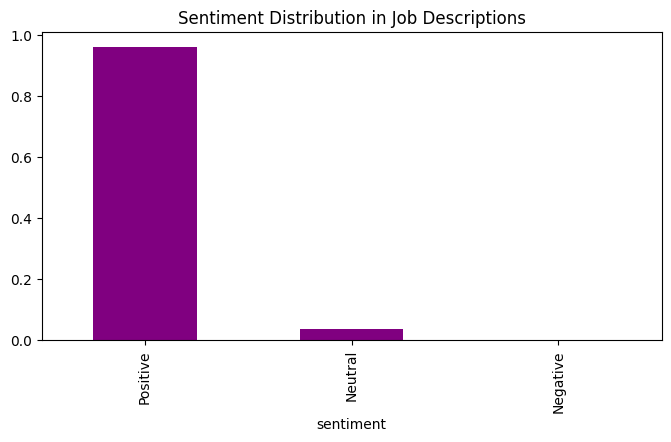

In [ ]:
from textblob import TextBlob

def get_sentiment_textblob(text):
    if not isinstance(text, str):
        return 'Neutral'
    polarity = TextBlob(text).sentiment.polarity
    if polarity > 0.05:
        return 'Positive'
    elif polarity < -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df['sentiment'] = df['job_description_text'].apply(get_sentiment_textblob)

# Sentiment distribution
df['sentiment'].value_counts(normalize=True).plot(kind='bar', color='purple', figsize=(8,4))
plt.title('Sentiment Distribution in Job Descriptions')
plt.show()

## Sentiment and Topic Trend Over Time

Visualize how sentiment and topic distribution change over time.

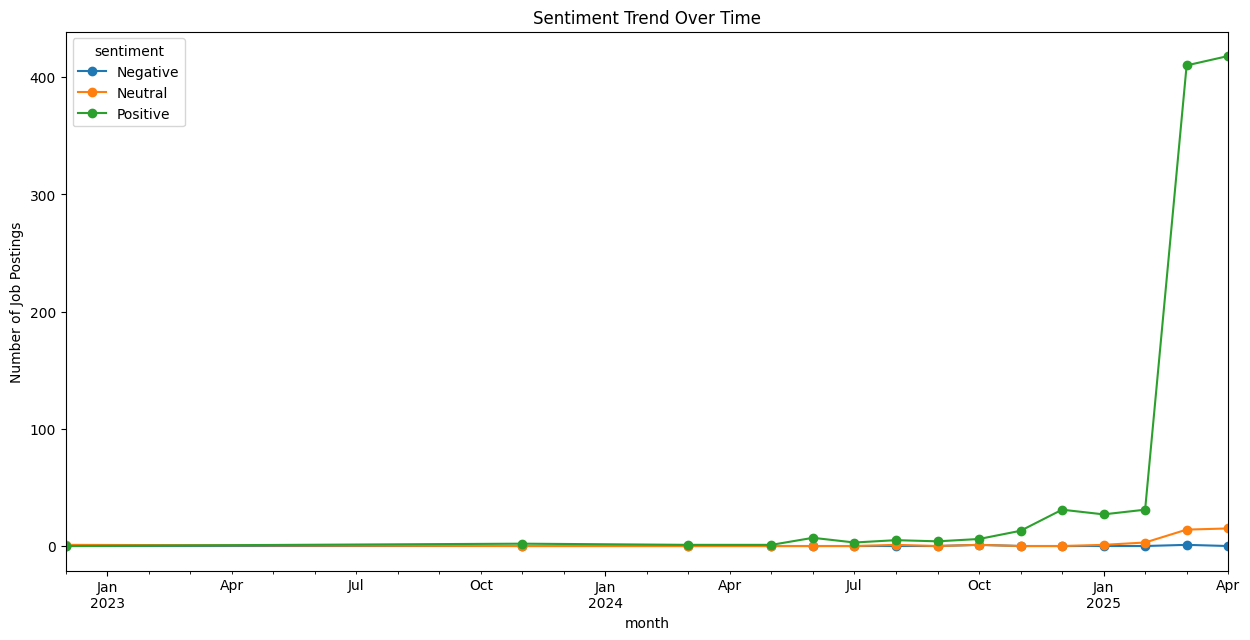

In [ ]:
df['job_posted_date'] = pd.to_datetime(df['job_posted_date'], errors='coerce')
df['month'] = df['job_posted_date'].dt.to_period('M')

# Sentiment trend
sentiment_trend = df.groupby(['month', 'sentiment']).size().unstack().fillna(0)
sentiment_trend.plot(kind='line', marker='o', figsize=(15,7), title='Sentiment Trend Over Time')
plt.ylabel('Number of Job Postings')
plt.show()

## Exploratory Data Analysis

Let's understand the dataset:
- Job postings by region.
- Job postings by company.
- Seniority level distribution.

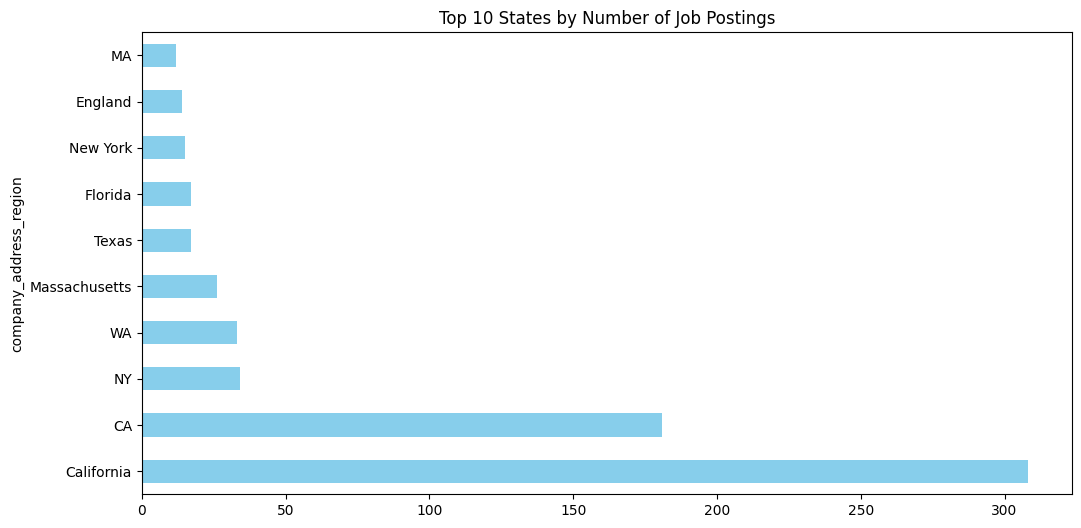

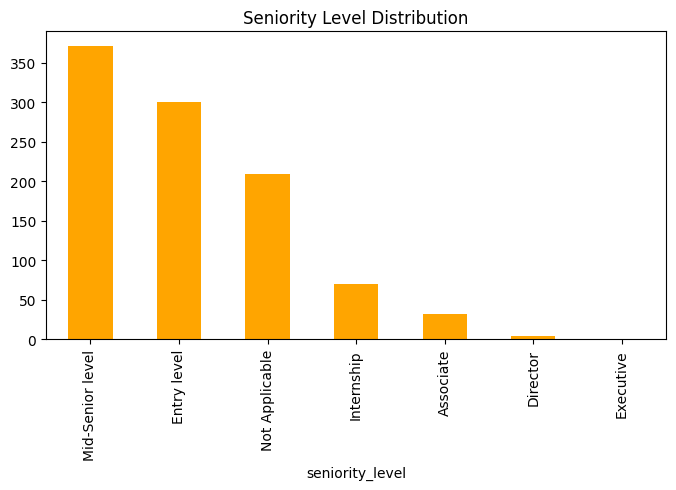

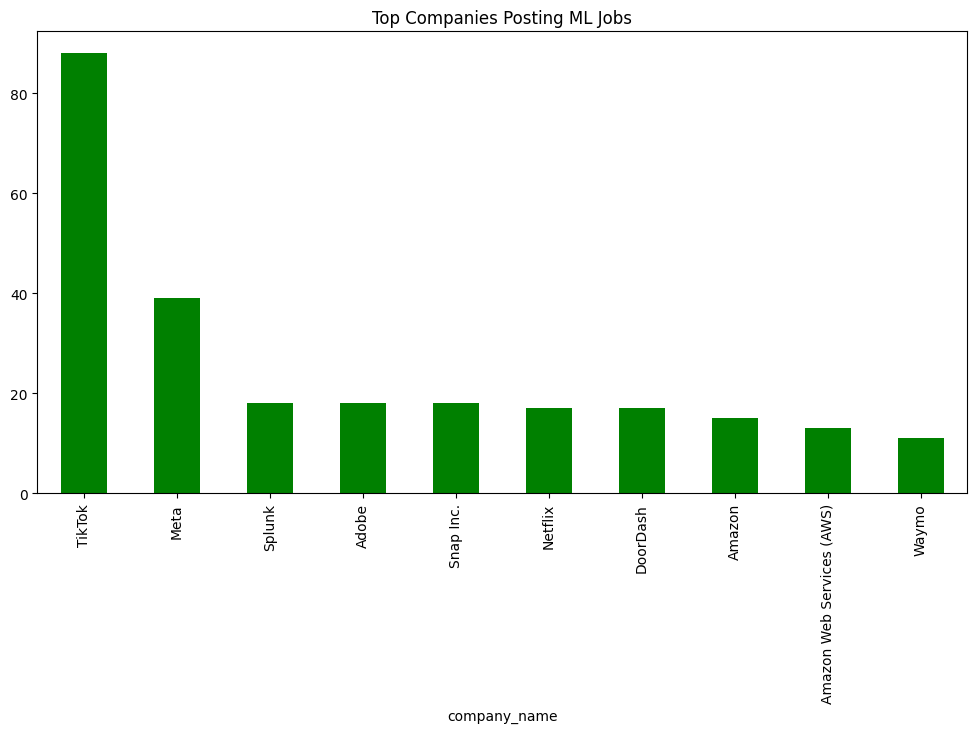

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Job postings by region
plt.figure(figsize=(12,6))
df['company_address_region'].value_counts().head(10).plot(kind='barh', color='skyblue')
plt.title('Top 10 States by Number of Job Postings')
plt.show()

# Seniority level distribution
plt.figure(figsize=(8,4))
df['seniority_level'].value_counts().plot(kind='bar', color='orange')
plt.title('Seniority Level Distribution')
plt.show()

# Job postings by company
plt.figure(figsize=(12,6))
df['company_name'].value_counts().head(10).plot(kind='bar', color='green')
plt.title('Top Companies Posting ML Jobs')
plt.show()

## Topic Distribution by Seniority Level

Explore how topics are distributed across different seniority levels.

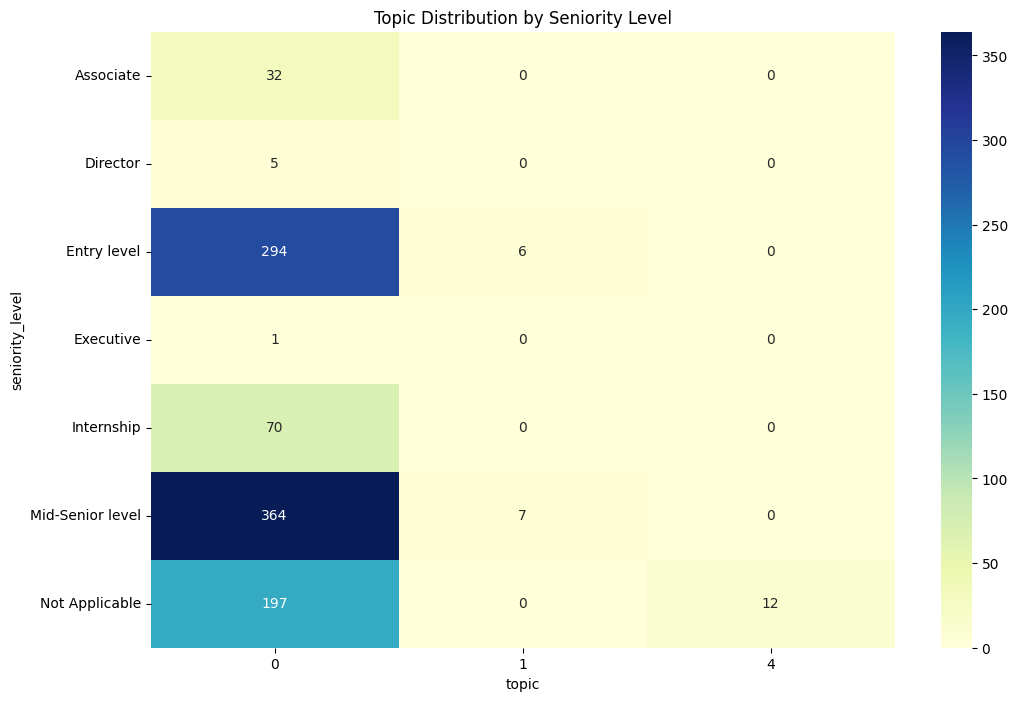

In [ ]:
df['topic'] = df['clean_text'].apply(lambda x: lda_model.transform(vectorizer.transform([x]))[0].argmax())

topic_seniority = df.groupby(['seniority_level', 'topic']).size().unstack().fillna(0)

plt.figure(figsize=(12,8))
sns.heatmap(topic_seniority, annot=True, fmt='.0f', cmap='YlGnBu')
plt.title('Topic Distribution by Seniority Level')
plt.show()

## Text Length Analysis

Explore the distribution of job description lengths.

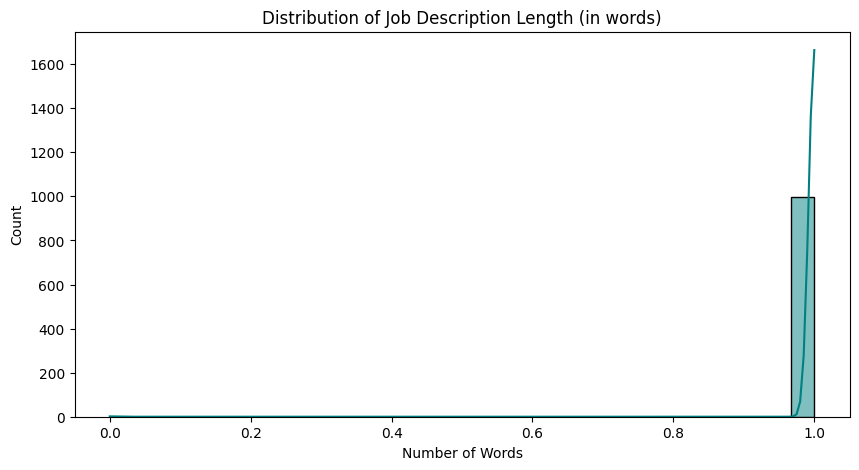

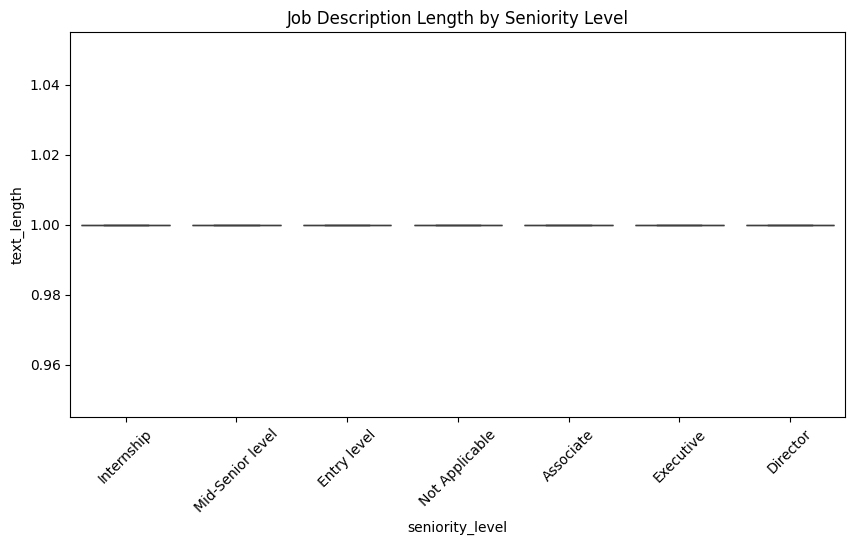

In [ ]:
# Calculate word count
df['text_length'] = df['clean_text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10,5))
sns.histplot(df['text_length'], bins=30, kde=True, color='teal')
plt.title('Distribution of Job Description Length (in words)')
plt.xlabel('Number of Words')
plt.show()

# Boxplot by seniority
plt.figure(figsize=(10,5))
sns.boxplot(x='seniority_level', y='text_length', data=df)
plt.title('Job Description Length by Seniority Level')
plt.xticks(rotation=45)
plt.show()

## Most Common Words in Job Descriptions

<ipython-input-29-63316768022c>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Word', data=common_words_df, palette='viridis')


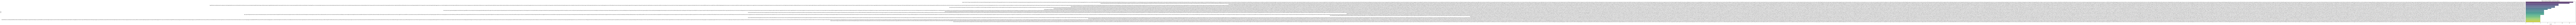

In [ ]:
from collections import Counter

# Get all words
all_words = ' '.join(df['clean_text']).split()
common_words = Counter(all_words).most_common(20)

# Convert to DataFrame
common_words_df = pd.DataFrame(common_words, columns=['Word', 'Count'])

# Plot
plt.figure(figsize=(12,5))
sns.barplot(x='Count', y='Word', data=common_words_df, palette='viridis')
plt.title('Most Common Words in Job Descriptions')
plt.show()

## Company-wise Sentiment Analysis

Understand how sentiment varies across different companies.

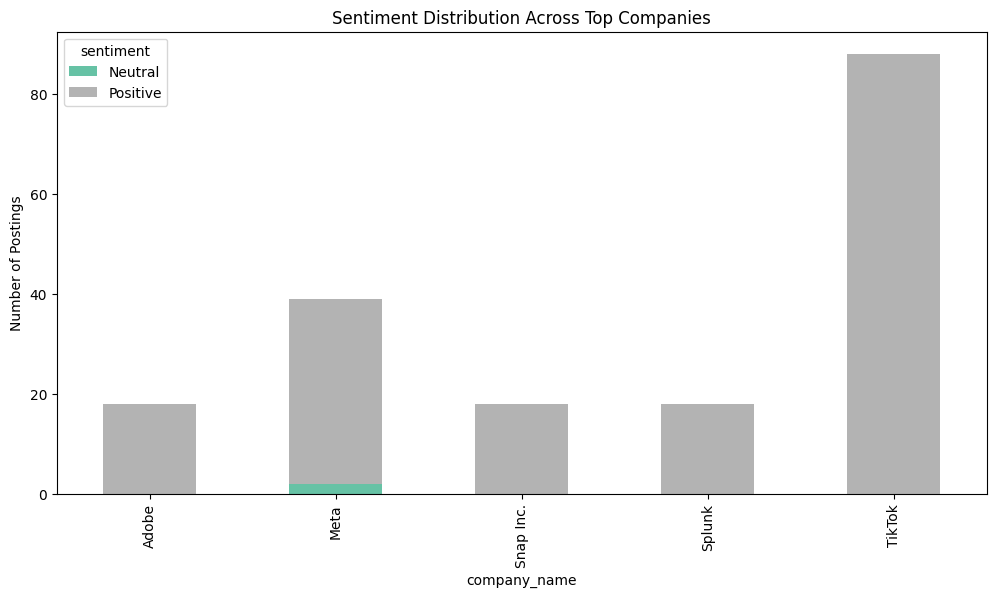

In [ ]:
top_companies = df['company_name'].value_counts().head(5).index
company_sentiment = df[df['company_name'].isin(top_companies)].groupby(['company_name', 'sentiment']).size().unstack().fillna(0)

company_sentiment.plot(kind='bar', stacked=True, figsize=(12,6), colormap='Set2')
plt.title('Sentiment Distribution Across Top Companies')
plt.ylabel('Number of Postings')
plt.show()

## Regional Sentiment Comparison

Analyze the sentiment of job descriptions across regions.

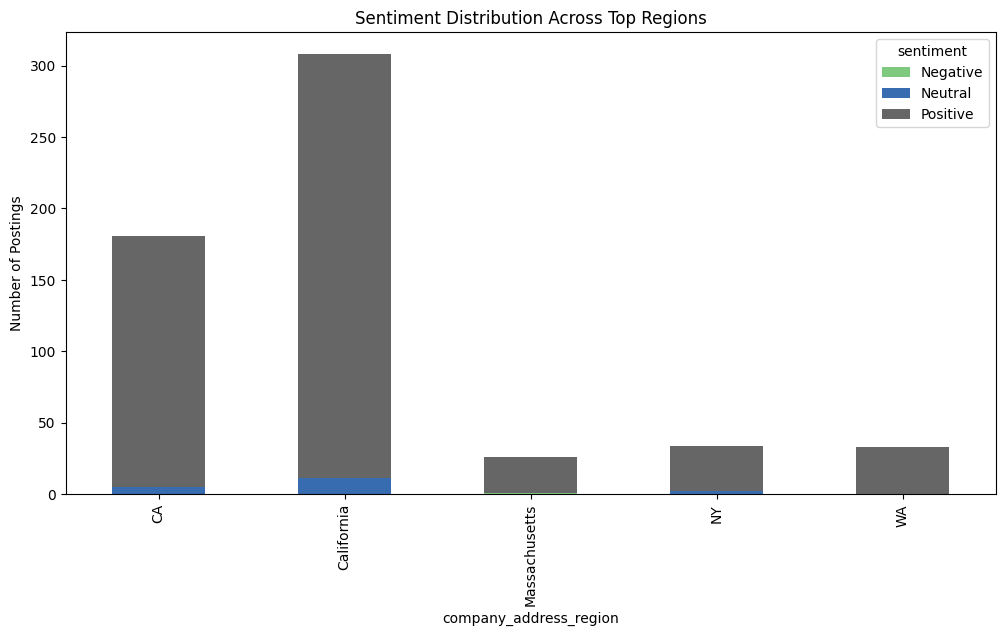

In [ ]:
top_regions = df['company_address_region'].value_counts().head(5).index
region_sentiment = df[df['company_address_region'].isin(top_regions)].groupby(['company_address_region', 'sentiment']).size().unstack().fillna(0)

region_sentiment.plot(kind='bar', stacked=True, figsize=(12,6), colormap='Accent')
plt.title('Sentiment Distribution Across Top Regions')
plt.ylabel('Number of Postings')
plt.show()

## Seniority Level vs Sentiment

Analyze how sentiment varies across different seniority levels.

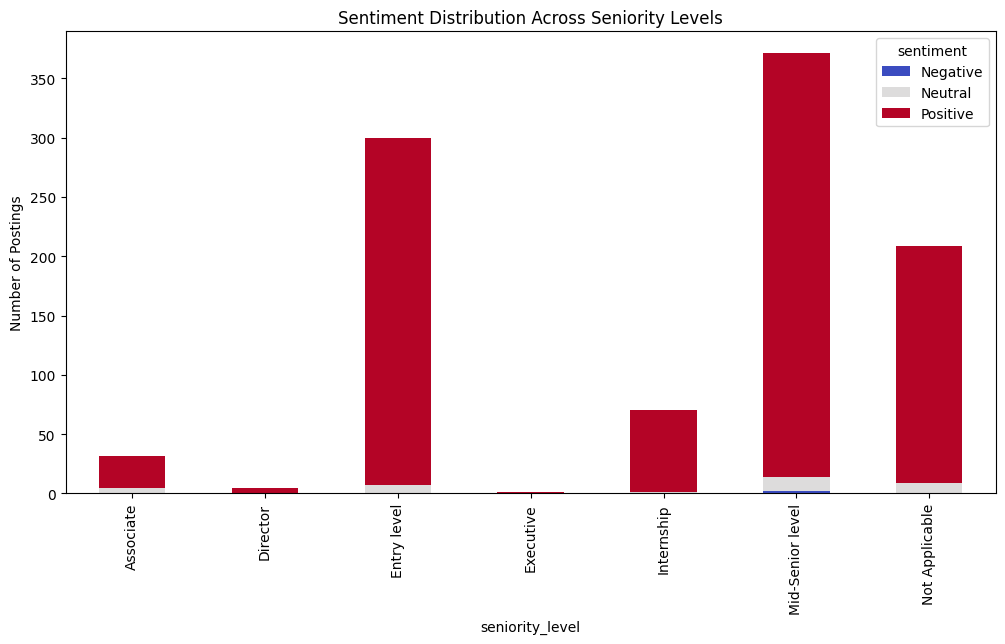

In [ ]:
seniority_sentiment = df.groupby(['seniority_level', 'sentiment']).size().unstack().fillna(0)

seniority_sentiment.plot(kind='bar', stacked=True, figsize=(12,6), colormap='coolwarm')
plt.title('Sentiment Distribution Across Seniority Levels')
plt.ylabel('Number of Postings')
plt.show()

## Interactive Dashboard using `ipywidgets`

This dashboard allows you to:
- Explore sentiment distribution.
- View top topics discovered.
- Analyze sentiment trend over time.

Use the dropdown below to interactively select the analysis view.

Dropdown(description='Select View:', index=2, layout=Layout(width='50%'), options=('Sentiment Distribution', '…

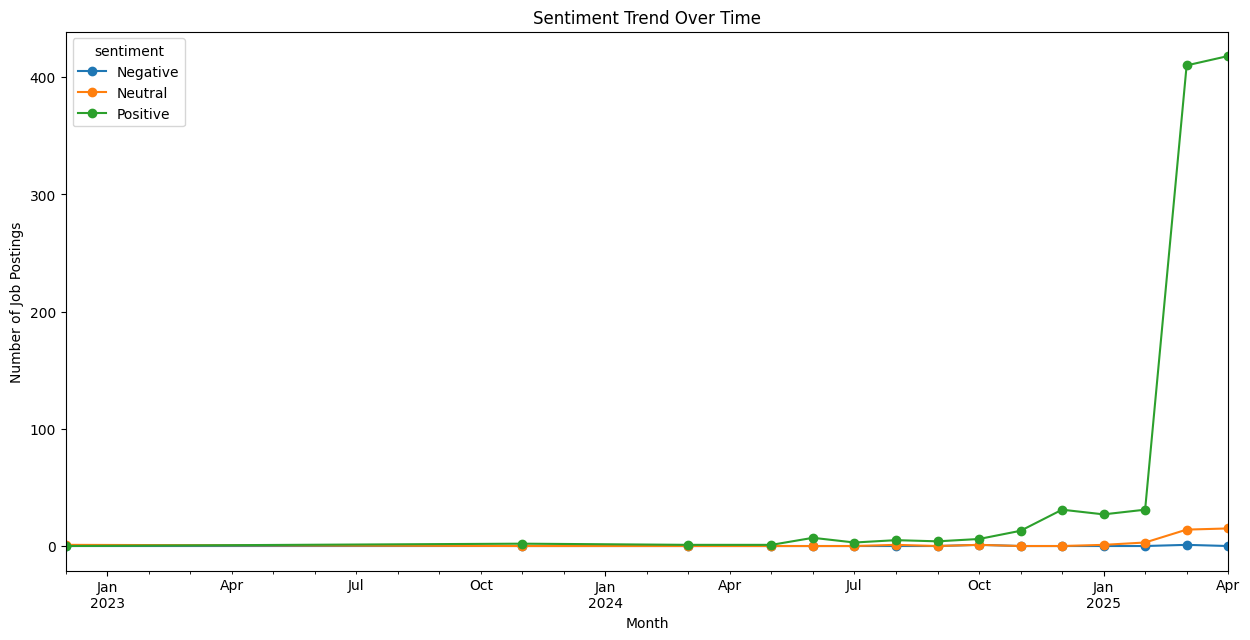

In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output

# Ensure your data is already preprocessed, with columns:
# df['clean_text'], df['sentiment'], df['job_posted_date']

# Function 1: Sentiment Distribution Plot
def plot_sentiment_distribution():
    df['sentiment'].value_counts(normalize=True).plot(kind='bar', color='purple', figsize=(8,4))
    plt.title('Sentiment Distribution in Job Descriptions')
    plt.xlabel('Sentiment')
    plt.ylabel('Percentage')
    plt.show()

# Function 2: Display Top Topics
def plot_top_topics():
    for topic in top_topics:
        print(topic)

# Function 3: Sentiment Trend Over Time
def plot_sentiment_trend():
    df['job_posted_date'] = pd.to_datetime(df['job_posted_date'], errors='coerce')
    df['month'] = df['job_posted_date'].dt.to_period('M')
    sentiment_trend = df.groupby(['month', 'sentiment']).size().unstack().fillna(0)
    sentiment_trend.plot(kind='line', marker='o', figsize=(15,7), title='Sentiment Trend Over Time')
    plt.ylabel('Number of Job Postings')
    plt.xlabel('Month')
    plt.show()

# Handler to update plot based on dropdown selection
def dashboard_handler(change):
    clear_output(wait=True)
    display(dashboard_selector)
    if change['new'] == 'Sentiment Distribution':
        plot_sentiment_distribution()
    elif change['new'] == 'Topics Overview':
        plot_top_topics()
    elif change['new'] == 'Sentiment Over Time':
        plot_sentiment_trend()

# Create dropdown
dashboard_selector = widgets.Dropdown(
    options=['Sentiment Distribution', 'Topics Overview', 'Sentiment Over Time'],
    description='Select View:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='50%')
)

# Link handler to dropdown changes
dashboard_selector.observe(dashboard_handler, names='value')

# Display the selector
display(dashboard_selector)

## Advanced Interactive Dashboard (ipywidgets)

Enhance the dashboard with:
- Heatmap: Topic vs Seniority Level.
- Word Cloud: Most common words in job descriptions.

Dropdown(description='Select View:', index=8, layout=Layout(width='70%'), options=('Sentiment Distribution', '…

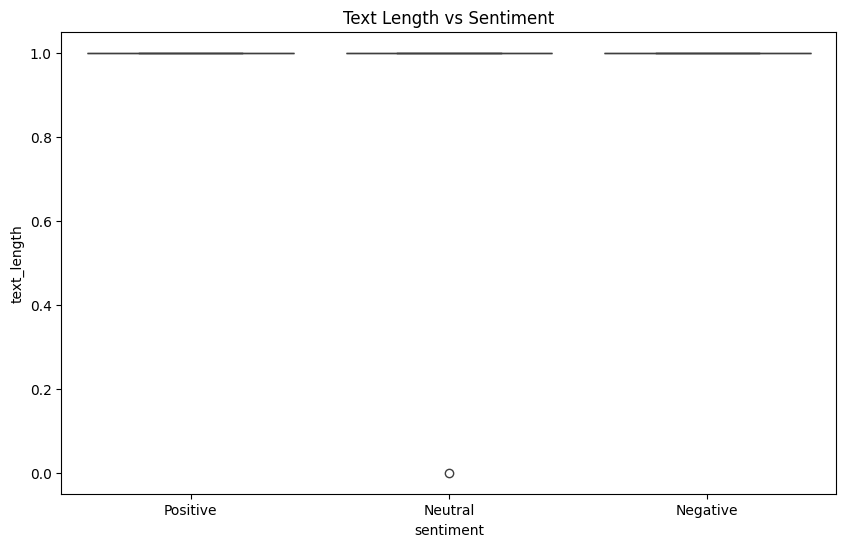

In [ ]:
from wordcloud import WordCloud
import seaborn as sns

# Advanced Function 1: Heatmap of Topic by Seniority Level
def plot_topic_seniority_heatmap():
    df['topic'] = df['clean_text'].apply(lambda x: lda_model.transform(vectorizer.transform([x]))[0].argmax())
    topic_seniority = df.groupby(['seniority_level', 'topic']).size().unstack().fillna(0)

    plt.figure(figsize=(12,8))
    sns.heatmap(topic_seniority, annot=True, fmt='.0f', cmap='YlGnBu')
    plt.title('Topic Distribution by Seniority Level')
    plt.xlabel('Topic')
    plt.ylabel('Seniority Level')
    plt.show()

# Advanced Function 2: Word Cloud of common words
def plot_word_cloud():
    all_words = ' '.join(df['clean_text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)

    plt.figure(figsize=(15,7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Most Common Words in Job Descriptions')
    plt.show()

# Advanced Function 3: Monthly Job Posting Trend
def plot_monthly_postings_trend():
    df['job_posted_date'] = pd.to_datetime(df['job_posted_date'], errors='coerce')
    df['month'] = df['job_posted_date'].dt.to_period('M')
    monthly_trend = df.groupby('month').size()

    monthly_trend.plot(kind='line', marker='o', figsize=(15,7), title='Monthly Job Posting Trend', color='green')
    plt.ylabel('Number of Job Postings')
    plt.xlabel('Month')
    plt.show()

# Advanced Function 4: Regional Distribution of Job Postings
def plot_region_distribution():
    df['company_address_region'].value_counts().head(10).plot(kind='bar', color='steelblue', figsize=(12,5))
    plt.title('Top 10 Regions by ML Job Postings')
    plt.xlabel('Region')
    plt.ylabel('Number of Postings')
    plt.show()

# Advanced Function 5: Company-wise Sentiment Distribution (Top 5 companies)
def plot_company_sentiment_distribution():
    top_companies = df['company_name'].value_counts().head(5).index
    company_sentiment = df[df['company_name'].isin(top_companies)].groupby(['company_name', 'sentiment']).size().unstack().fillna(0)
    company_sentiment.plot(kind='bar', stacked=True, figsize=(12,6), colormap='Pastel2')
    plt.title('Sentiment Distribution Across Top Companies')
    plt.ylabel('Number of Postings')
    plt.show()

# Advanced Function 6: Sentiment vs Text Length
def plot_sentiment_vs_text_length():
    plt.figure(figsize=(10,6))
    sns.boxplot(x='sentiment', y='text_length', data=df)
    plt.title('Text Length vs Sentiment')
    plt.show()

# handler to include all views
def super_dashboard_handler(change):
    clear_output(wait=True)
    display(super_dashboard_selector)
    if change['new'] == 'Sentiment Distribution':
        plot_sentiment_distribution()
    elif change['new'] == 'Topics Overview':
        plot_top_topics()
    elif change['new'] == 'Sentiment Over Time':
        plot_sentiment_trend()
    elif change['new'] == 'Topic vs Seniority Heatmap':
        plot_topic_seniority_heatmap()
    elif change['new'] == 'Word Cloud':
        plot_word_cloud()
    elif change['new'] == 'Monthly Posting Trend':
        plot_monthly_postings_trend()
    elif change['new'] == 'Regional Distribution':
        plot_region_distribution()
    elif change['new'] == 'Company Sentiment Distribution':
        plot_company_sentiment_distribution()
    elif change['new'] == 'Sentiment vs Text Length':
        plot_sentiment_vs_text_length()

# dropdown with all options
super_dashboard_selector = widgets.Dropdown(
    options=[
        'Sentiment Distribution', 'Topics Overview', 'Sentiment Over Time',
        'Topic vs Seniority Heatmap', 'Word Cloud',
        'Monthly Posting Trend', 'Regional Distribution',
        'Company Sentiment Distribution', 'Sentiment vs Text Length'
    ],
    description='Select View:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='70%')
)

super_dashboard_selector.observe(super_dashboard_handler, names='value')

display(super_dashboard_selector)